## Classification of Game Outcomes with LGBM
#### Predicting the NCAA Mens Basketball Tournament, Game-by-Game

Light GBM is a tree-based gradient-boosting algorithm. Instead of growing trees horizontally, LGBM grows trees vertically (leaf-wise instead of level-wise). This change in methodology can reduce loss better than a level-wise algorithm, but is subject to problems with overfitting.

The following code utilizes the LGBM algorithm, with hyperparameter tuning through grid search, to predict the outcomes of the Mens NCAA College Basketball Tournament, as part of the Kaggle challenge.

In [1]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
# for training models
#tourney_result = import_data('Data/trainfull.csv')
#test_df = import_data('Data/testfull.csv')

# for submission models
tourney_result = import_data('Data/train_data_through_2020.csv')
test_df = import_data('Data/test_data_2021_season.csv')

Memory usage of dataframe is 22.90 MB
Memory usage after optimization is: 5.63 MB
Decreased by 75.4%
Memory usage of dataframe is 0.42 MB
Memory usage after optimization is: 0.10 MB
Decreased by 75.3%


In [4]:
tourney_result.head()

,Season,Team1,Team2,result,WScore,LScore,T1Rank,T1Conf,T1adj_EM,T1adj_OffEff,...,T2Luck,T2sos_adj_em,T2ncsos_adj_em,OffDiffadj,DefDiffadj,EMDiffadj,t1diff,t2diff,sos_diff,ncsos_diff
0,2002,1112,1268,1,71,67,13.0,1.0,20.546875,119.3125,...,0.024994,9.882812,1.620117,0.099976,8.898438,-8.710938,20.500000,29.296875,4.339844,15.937500
1,2002,1196,1396,1,72,64,7.0,1.0,24.718750,115.1250,...,-0.037994,8.039062,14.742188,1.099609,-10.000000,11.148438,24.703125,13.601562,1.070312,-15.296875
2,2002,1112,1196,1,75,71,13.0,1.0,20.546875,119.3125,...,-0.072998,9.109375,-0.560059,4.199219,8.398438,-4.179688,20.500000,24.703125,5.109375,18.125000
3,2002,1268,1396,1,82,74,3.0,1.0,29.250000,119.1875,...,-0.037994,8.039062,14.742188,5.199219,-10.500000,15.679688,29.296875,13.601562,1.839844,-13.117188
4,2002,1116,1263,1,64,47,57.0,1.0,12.562500,108.8125,...,0.007000,-10.390625,-7.199219,14.601562,-11.898438,26.468750,12.601562,-13.898438,21.640625,12.031250


In [5]:
# model selects all available columns, so must subset desired columns at this point
tourney_result = tourney_result[['result','OffDiffadj','DefDiffadj','T1Luck','T2Luck','sos_diff','ncsos_diff']]
test_df = test_df[['OffDiffadj','DefDiffadj','T1Luck','T2Luck','sos_diff','ncsos_diff']]

In [6]:
tourney_result.head()

,result,OffDiffadj,DefDiffadj,T1Luck,T2Luck,sos_diff,ncsos_diff
0,1,0.099976,8.898438,0.078979,0.024994,4.339844,15.937500
1,1,1.099609,-10.000000,-0.072998,-0.037994,1.070312,-15.296875
2,1,4.199219,8.398438,0.078979,-0.072998,5.109375,18.125000
3,1,5.199219,-10.500000,0.024994,-0.037994,1.839844,-13.117188
4,1,14.601562,-11.898438,-0.062012,0.007000,21.640625,12.031250


In [7]:
test_df.head()

,OffDiffadj,DefDiffadj,T1Luck,T2Luck,sos_diff,ncsos_diff
0,-6.300781,3.800781,0.122986,0.050995,-14.226562,-6.300781
1,-17.500000,6.101562,0.122986,0.008003,-20.906250,-7.378906
2,-11.898438,3.199219,0.122986,-0.029007,-19.156250,-0.709961
3,-12.203125,0.500000,0.122986,0.024994,-6.691406,-8.531250
4,1.900391,0.600098,0.122986,0.035004,-7.011719,-0.810059


In [8]:
X = tourney_result.drop('result', axis=1)
y = tourney_result.result

In [9]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23, stratify=y)

In [10]:
# prepare learning rate shrinkage
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [11]:
# set fit parameters, use early stopping to avoid overtraining and specification of # of trees
fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [12]:
# set up hyperparameter search
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(3, 500), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [13]:
# Hyperparameter grid - from bayesian 
# https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

In [14]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Randomized Search CV

In [15]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=23, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=23,
    verbose=0)

In [26]:
# find optimal hyperparameters
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.837538
[200]	valid's auc: 0.837668
Early stopping, best iteration is:
[161]	valid's auc: 0.837691
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.837681
[200]	valid's auc: 0.837892
Early stopping, best iteration is:
[169]	valid's auc: 0.837894
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.837546
[200]	valid's auc: 0.83773
Early stopping, best iteration is:
[199]	valid's auc: 0.83773
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.837513
[200]	valid's auc: 0.837676
[300]	valid's auc: 0.837675
Early stopping, best iteration is:
[203]	valid's auc: 0.837679
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.837276
[200]	valid's auc: 0.837471
Early stopping, best iteration is:
[189]	valid's auc: 0.837478
Training until validation scores don't improve for 100 rounds
[100]	v

In [27]:
# input best scores from search as new opt_parameters
opt_parameters = {'colsample_bytree': 0.5814922697483688, 
                  'min_child_samples': 293, 
                  'min_child_weight': 0.1, 
                  'num_leaves': 5, 
                  'reg_alpha': 10, 
                  'reg_lambda': 10, 
                  'subsample': 0.8358356155097291}

clf_sw = lgb.LGBMClassifier(**clf.get_params())

#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.5814922697483688, metric='None',
               min_child_samples=293, min_child_weight=0.1, n_estimators=5000,
               n_jobs=4, num_leaves=5, random_state=23, reg_alpha=10,
               reg_lambda=10, subsample=0.8358356155097291)

### Grid Search CV

In [29]:
# fit the model
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 100 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid's auc: 0.83805
[200]	valid's auc: 0.838491
Early stopping, best iteration is:
[189]	valid's auc: 0.838507
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.838352
[200]	valid's auc: 0.838808
Early stopping, best iteration is:
[165]	valid's auc: 0.838814
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.838558
[200]	valid's auc: 0.839046
[300]	valid's auc: 0.838976
Early stopping, best iteration is:
[219]	valid's auc: 0.839068
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.838523
[200]	valid's auc: 0.838878
[300]	valid's auc: 0.838813
Early stopping, best iteration is:
[200]	valid's auc: 0.838878
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.838397
[200]	valid's auc: 0.838726
[300]	valid's auc: 0.838693
Early stopping, best iteration is:
[236]	valid's auc: 0.838784
Training until validation scores don't improve for 100 rounds
[100]	valid'

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.6s finished


[100]	valid's auc: 0.838266
[200]	valid's auc: 0.83892
[300]	valid's auc: 0.83885
Early stopping, best iteration is:
[200]	valid's auc: 0.83892
Best score reached: 0.8373358186104888 with params: {'scale_pos_weight': 6} 


### Final Model Fit with Optimized Hyperparameters

In [30]:
#Configure from the HP optimisation - shortcut from doing above lines of code
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())

#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, 
              callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.837379
[200]	valid's auc: 0.838557
[300]	valid's auc: 0.838731
[400]	valid's auc: 0.838775
[500]	valid's auc: 0.838822
[600]	valid's auc: 0.838811
Early stopping, best iteration is:
[529]	valid's auc: 0.838834


LGBMClassifier(colsample_bytree=0.5814922697483688, metric='None',
               min_child_samples=293, min_child_weight=0.1, n_estimators=5000,
               n_jobs=4, num_leaves=5, random_state=23, reg_alpha=10,
               reg_lambda=10, subsample=0.8358356155097291)

### Feature Importance

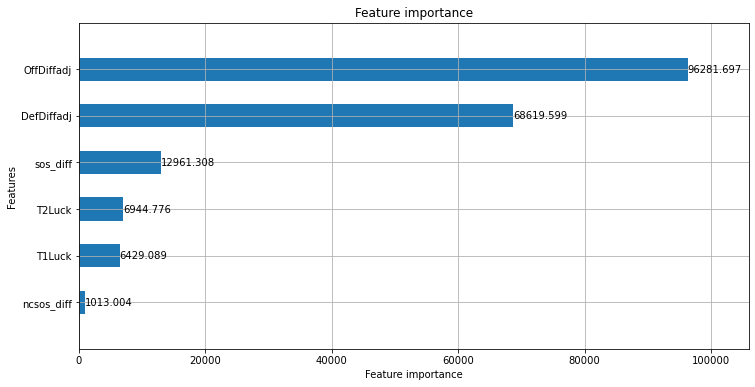

In [31]:
lgb.plot_importance(clf_final, 
                    height=0.5, max_num_features=20, ignore_zero = False, 
                    figsize = (12,6), importance_type ='gain')

### Make Predictions from the Model

In [32]:
probabilities = clf_final.predict_proba(test_df)
probabilities

array([[0.85464326, 0.14535674],
       [0.9744303 , 0.0255697 ],
       [0.90942603, 0.09057397],
       ...,
       [0.34176992, 0.65823008],
       [0.10306488, 0.89693512],
       [0.20281806, 0.79718194]])

In [33]:
submission_df = pd.read_csv('Data/submission_stage_two_2021.csv')
submission = pd.DataFrame({
    'ID': submission_df['ID'],
    'Pred':     [ row[1] for row in probabilities]
})

submission

,ID,Pred
0,2021_1101_1104,0.145357
1,2021_1101_1111,0.025570
2,2021_1101_1116,0.090574
3,2021_1101_1124,0.179056
4,2021_1101_1140,0.628401
...,...,...
2273,2021_1452_1457,0.370024
2274,2021_1452_1458,0.743062
2275,2021_1455_1457,0.658230
2276,2021_1455_1458,0.896935


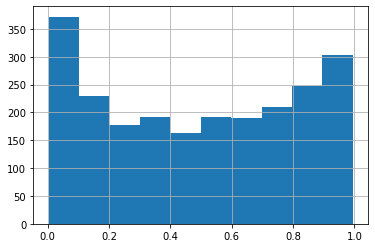

In [34]:
# a quick glance at the predictions across the entire range of matchups
submission['Pred'].hist()

In [35]:
submission.to_csv('Data/submission_lgbm.csv', index=False)